<a href="https://colab.research.google.com/github/r-bitbot/Malnutrition-Detection/blob/main/malnutrition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19
import keras_hub
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Sequential, layers
from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = '/content/drive/My Drive/'
img_size = (224, 224)
batch_size = 16

In [4]:
datagen_vgg = ImageDataGenerator(
    preprocessing_function=vgg_preprocess_input,
    validation_split=0.2,
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    brightness_range=[0.7,1.3],
    horizontal_flip=True,
    vertical_flip=True
)

datagen_resnet = ImageDataGenerator(
    preprocessing_function=resnet_preprocess_input,
    validation_split=0.2,
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    brightness_range=[0.7,1.3],
    horizontal_flip=True,
    vertical_flip=True
)

In [5]:
train_gen_16 = datagen_vgg.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['malnourished', 'healthy'],
    subset='training'
)

val_gen_16 = datagen_vgg.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['malnourished', 'healthy'],
    subset='validation'
)

Found 216 images belonging to 2 classes.
Found 53 images belonging to 2 classes.


In [6]:
base_model_16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_16.trainable = False

x = base_model_16.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_16 = Model(inputs=base_model_16.input, outputs=outputs)

In [7]:
model_16.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [8]:
counter_16 = Counter(train_gen_16.classes)
total_16 = sum(counter_16.values())
class_weight_16 = {i: total_16/(2*count) for i, count in counter_16.items()}
print("Class weights:", class_weight_16)

Class weights: {np.int32(0): 0.6792452830188679, np.int32(1): 1.894736842105263}


In [9]:
callbacks_16 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_vgg16_model.h5', save_best_only=True)
]

history_16 = model_16.fit(
    train_gen_16,
    epochs=20,
    validation_data=val_gen_16,
    class_weight=class_weight_16,
    callbacks=callbacks_16
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.6373 - loss: 0.7518

14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6362 - loss: 0.7553 - val_accuracy: 0.7358 - val_loss: 0.6079
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 430ms/step - accuracy: 0.6047 - loss: 0.7415 - val_accuracy: 0.7925 - val_loss: 0.6489
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 350ms/step - accuracy: 0.5081 - loss: 0.8300 - val_accuracy: 0.4717 - val_loss: 0.6910
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 374ms/step - accuracy: 0.6229 - loss: 0.6422 - val_accuracy: 0.8491 - val_loss: 0.6204
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.5859 - loss: 0.6582

14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - accuracy: 0.5870 - loss: 0.6576 - val_accuracy: 0.8113 - val_loss: 0.5909
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.7063 - loss: 0.6087

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 443ms/step - accuracy: 0.7049 - loss: 0.6100 - val_accuracy: 0.7925 - val_loss: 0.5749
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.7444 - loss: 0.6576

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - accuracy: 0.7411 - loss: 0.6569 - val_accuracy: 0.8679 - val_loss: 0.5589
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 529ms/step - accuracy: 0.6725 - loss: 0.6671 - val_accuracy: 0.9057 - val_loss: 0.5601
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.7454 - loss: 0.5387

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 345ms/step - accuracy: 0.7438 - loss: 0.5415 - val_accuracy: 0.9434 - val_loss: 0.5436
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.6198 - loss: 0.6047

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - accuracy: 0.6220 - loss: 0.6040 - val_accuracy: 0.9434 - val_loss: 0.5334
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.6719 - loss: 0.5926

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 423ms/step - accuracy: 0.6709 - loss: 0.5919 - val_accuracy: 0.8679 - val_loss: 0.5123
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 338ms/step - accuracy: 0.7347 - loss: 0.6298 - val_accuracy: 0.9057 - val_loss: 0.5185
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.7613 - loss: 0.5241

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 422ms/step - accuracy: 0.7615 - loss: 0.5250 - val_accuracy: 0.9245 - val_loss: 0.4730
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 345ms/step - accuracy: 0.7896 - loss: 0.5191 - val_accuracy: 0.9057 - val_loss: 0.4797
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 339ms/step - accuracy: 0.7784 - loss: 0.5182 - val_accuracy: 0.8868 - val_loss: 0.4783
Epoch 16/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6872 - loss: 0.5564

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 460ms/step - accuracy: 0.6911 - loss: 0.5562 - val_accuracy: 0.9057 - val_loss: 0.4536
Epoch 17/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 345ms/step - accuracy: 0.7787 - loss: 0.5109 - val_accuracy: 0.9057 - val_loss: 0.4779
Epoch 18/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.7669 - loss: 0.5472

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 502ms/step - accuracy: 0.7670 - loss: 0.5451 - val_accuracy: 0.9245 - val_loss: 0.4523
Epoch 19/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 335ms/step - accuracy: 0.8194 - loss: 0.4929 - val_accuracy: 0.9245 - val_loss: 0.4648
Epoch 20/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.7398 - loss: 0.5264

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 461ms/step - accuracy: 0.7442 - loss: 0.5241 - val_accuracy: 0.9245 - val_loss: 0.4302


In [10]:
def predict_image(img_path, model, img_size=(224,224)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model_16.predict(img_array)[0][0]
    return "Healthy" if pred > 0.5 else "Malnourished"

In [11]:
print(predict_image('/content/drive/My Drive/malnourished/malnourished_468.jpg', model_16))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Malnourished


In [12]:
print(predict_image('/content/drive/My Drive/healthy/healthy_113.jpg', model_16))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Healthy


In [13]:
train_gen_19 = datagen_vgg.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['malnourished', 'healthy'],
    subset='training'
)

val_gen_19 = datagen_vgg.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['malnourished', 'healthy'],
    subset='validation'
)

Found 216 images belonging to 2 classes.
Found 53 images belonging to 2 classes.


In [14]:
base_model_19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_19.trainable = False

y = base_model_19.output
y = GlobalAveragePooling2D()(y)
y = Dense(256, activation='relu')(y)
y = Dropout(0.5)(y)
outputs = Dense(1, activation='sigmoid')(y)

model_19 = Model(inputs=base_model_19.input, outputs=outputs)

In [15]:
model_19.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [16]:
counter_19 = Counter(train_gen_19.classes)
total_19 = sum(counter_19.values())
class_weight_19 = {i: total_19/(2*count) for i, count in counter_19.items()}
print("Class weights:", class_weight_19)

Class weights: {np.int32(0): 0.6792452830188679, np.int32(1): 1.894736842105263}


In [17]:
callbacks_19 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_vgg19_model.h5', save_best_only=True)
]

history_19 = model_19.fit(
    train_gen_19,
    epochs=20,
    validation_data=val_gen_19,
    class_weight=class_weight_19,
    callbacks=callbacks_19
)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.6392 - loss: 0.7906

14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 667ms/step - accuracy: 0.6386 - loss: 0.7870 - val_accuracy: 0.7358 - val_loss: 0.6513
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 356ms/step - accuracy: 0.5860 - loss: 0.7010 - val_accuracy: 0.6415 - val_loss: 0.6746
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 425ms/step - accuracy: 0.5837 - loss: 0.7152 - val_accuracy: 0.5283 - val_loss: 0.6842
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 345ms/step - accuracy: 0.5738 - loss: 0.7367 - val_accuracy: 0.6226 - val_loss: 0.6704
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.5280 - loss: 0.6925

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 401ms/step - accuracy: 0.5295 - loss: 0.6924 - val_accuracy: 0.7547 - val_loss: 0.6368
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.6519 - loss: 0.6542

14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 358ms/step - accuracy: 0.6489 - loss: 0.6562 - val_accuracy: 0.7547 - val_loss: 0.6329
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.5919 - loss: 0.6722

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 471ms/step - accuracy: 0.5928 - loss: 0.6711 - val_accuracy: 0.8302 - val_loss: 0.6131
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.6539 - loss: 0.6219

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 382ms/step - accuracy: 0.6519 - loss: 0.6232 - val_accuracy: 0.7925 - val_loss: 0.5985
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.5866 - loss: 0.6036

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 459ms/step - accuracy: 0.5892 - loss: 0.6042 - val_accuracy: 0.8679 - val_loss: 0.5797
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7385 - loss: 0.5547

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 361ms/step - accuracy: 0.7349 - loss: 0.5572 - val_accuracy: 0.8113 - val_loss: 0.5556
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 371ms/step - accuracy: 0.7125 - loss: 0.6014 - val_accuracy: 0.7925 - val_loss: 0.5720
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.6726 - loss: 0.5930

14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 365ms/step - accuracy: 0.6741 - loss: 0.5943 - val_accuracy: 0.8491 - val_loss: 0.5450
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 441ms/step - accuracy: 0.7052 - loss: 0.5731 - val_accuracy: 0.8679 - val_loss: 0.5577
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.6765 - loss: 0.6658

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 369ms/step - accuracy: 0.6774 - loss: 0.6627 - val_accuracy: 0.9057 - val_loss: 0.5377
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.7194 - loss: 0.6273

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 410ms/step - accuracy: 0.7193 - loss: 0.6245 - val_accuracy: 0.8491 - val_loss: 0.5277
Epoch 16/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7209 - loss: 0.5396

14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 365ms/step - accuracy: 0.7198 - loss: 0.5432 - val_accuracy: 0.8868 - val_loss: 0.5083
Epoch 17/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 423ms/step - accuracy: 0.7054 - loss: 0.5521 - val_accuracy: 0.8302 - val_loss: 0.5282
Epoch 18/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 347ms/step - accuracy: 0.7560 - loss: 0.5475 - val_accuracy: 0.8302 - val_loss: 0.5131
Epoch 19/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.8310 - loss: 0.4877

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 483ms/step - accuracy: 0.8284 - loss: 0.4896 - val_accuracy: 0.9057 - val_loss: 0.4894
Epoch 20/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 358ms/step - accuracy: 0.7642 - loss: 0.5575 - val_accuracy: 0.8113 - val_loss: 0.4919


In [18]:
def predict_image(img_path, model, img_size=(224,224)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model_19.predict(img_array)[0][0]
    return "Healthy" if pred > 0.5 else "Malnourished"

In [19]:
print(predict_image('/content/drive/My Drive/malnourished/malnourished_468.jpg', model_19))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Malnourished


In [20]:
print(predict_image('/content/drive/My Drive/healthy/healthy_113.jpg', model_19))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Healthy


In [21]:
train_gen_res = datagen_resnet.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['malnourished', 'healthy'],
    subset='training'
)

val_gen_res = datagen_resnet.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['malnourished', 'healthy'],
    subset='validation'
)

Found 216 images belonging to 2 classes.
Found 53 images belonging to 2 classes.


In [22]:
model_res = keras_hub.models.ResNetBackbone.from_preset("resnet_18_imagenet")

In [23]:
model_res = Sequential([
    model_res,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.7),
    layers.Dense(1, activation='sigmoid')
])

In [24]:
model_res.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [25]:
counter_res = Counter(train_gen_res.classes)
total_res = sum(counter_res.values())
class_weight_res = {i: total_res/(2*count) for i, count in counter_res.items()}
print("Class weights:", class_weight_res)

Class weights: {np.int32(0): 0.6792452830188679, np.int32(1): 1.894736842105263}


In [26]:
callbacks_res = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_resnet_model.h5', save_best_only=True)
]

history_res = model_res.fit(
    train_gen_res,
    epochs=20,
    validation_data=val_gen_res,
    class_weight=class_weight_res,
    callbacks=callbacks_res
)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4896 - loss: 0.7984

14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4885 - loss: 0.7955 - val_accuracy: 0.4340 - val_loss: 0.7165
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.4820 - loss: 0.7358

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 451ms/step - accuracy: 0.4829 - loss: 0.7348 - val_accuracy: 0.7547 - val_loss: 0.6255
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.5995 - loss: 0.7450

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 389ms/step - accuracy: 0.6018 - loss: 0.7390 - val_accuracy: 0.8491 - val_loss: 0.5483
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7431 - loss: 0.6079

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 418ms/step - accuracy: 0.7421 - loss: 0.6094 - val_accuracy: 0.8302 - val_loss: 0.5410
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7560 - loss: 0.6261

14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 366ms/step - accuracy: 0.7563 - loss: 0.6230 - val_accuracy: 0.8868 - val_loss: 0.5147
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8218 - loss: 0.5389

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.8223 - loss: 0.5383 - val_accuracy: 0.9245 - val_loss: 0.4650
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.7973 - loss: 0.5246

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - accuracy: 0.7988 - loss: 0.5235 - val_accuracy: 0.9245 - val_loss: 0.3995
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8012 - loss: 0.4763

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 520ms/step - accuracy: 0.8034 - loss: 0.4747 - val_accuracy: 0.9245 - val_loss: 0.3963
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8766 - loss: 0.3937

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.8765 - loss: 0.3950 - val_accuracy: 0.9623 - val_loss: 0.3448
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 465ms/step - accuracy: 0.8170 - loss: 0.4557 - val_accuracy: 0.9057 - val_loss: 0.3496
Epoch 11/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9031 - loss: 0.3648

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accuracy: 0.9043 - loss: 0.3635 - val_accuracy: 0.9057 - val_loss: 0.3086
Epoch 12/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9293 - loss: 0.2948

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 374ms/step - accuracy: 0.9282 - loss: 0.2952 - val_accuracy: 0.9245 - val_loss: 0.2673
Epoch 13/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.8894 - loss: 0.2673

14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.8900 - loss: 0.2674 - val_accuracy: 0.9057 - val_loss: 0.2298
Epoch 14/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 406ms/step - accuracy: 0.9135 - loss: 0.3051 - val_accuracy: 0.9434 - val_loss: 0.2503
Epoch 15/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9535 - loss: 0.2221

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - accuracy: 0.9535 - loss: 0.2217 - val_accuracy: 0.9434 - val_loss: 0.2129
Epoch 16/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accuracy: 0.9686 - loss: 0.1686 - val_accuracy: 0.9245 - val_loss: 0.2562
Epoch 17/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.9668 - loss: 0.1514 - val_accuracy: 0.9434 - val_loss: 0.2326
Epoch 18/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 407ms/step - accuracy: 0.9775 - loss: 0.1526 - val_accuracy: 0.8868 - val_loss: 0.2502
Epoch 19/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9550 - loss: 0.1979

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - accuracy: 0.9546 - loss: 0.1965 - val_accuracy: 0.9811 - val_loss: 0.1591
Epoch 20/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step - accuracy: 0.9693 - loss: 0.1148 - val_accuracy: 0.9245 - val_loss: 0.2020


In [27]:
def predict_image(img_path, model, img_size=(224,224)):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)[0][0]
    return "Healthy" if pred > 0.5 else "Malnourished"

In [28]:
print(predict_image('/content/drive/My Drive/malnourished/malnourished_468.jpg', model_res))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Malnourished


In [29]:
print(predict_image('/content/drive/My Drive/healthy/healthy_113.jpg', model_res))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Healthy


In [30]:
from sklearn.metrics import accuracy_score, precision_score, classification_report

def get_preds_labels(generator, model):
    preds = []
    labels = []
    for i in range(len(generator)):
        x, y_true = generator[i]
        y_pred = model.predict(x)
        preds.extend(y_pred.flatten())
        labels.extend(y_true)
    preds = np.array(preds) > 0.5
    labels = np.array(labels).astype(bool)
    return labels, preds

In [31]:
labels_16, preds_16 = get_preds_labels(val_gen_16, model_16)
accuracy_16 = accuracy_score(labels_16, preds_16)
precision_16 = precision_score(labels_16, preds_16)
report_16 = classification_report(labels_16, preds_16, target_names=['Malnourished', 'Healthy'])

print("VGG16 Accuracy:", accuracy_16)
print("VGG16 Precision:", precision_16)
print(report_16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
VGG16 Accuracy: 0.8867924528301887
VGG16 Precision: 0.9
              precision    recall  f1-score   support

Malnourished       0.88      0.97      0.93        39
     Healthy       0.90      0.64      0.75        14

    accuracy                           0.89        53
   macro avg       0.89      0.81      0.84        53
weighted avg       0.89      0.89      0.88        53



In [32]:
labels_19, preds_19 = get_preds_labels(val_gen_19, model_19)
accuracy_19 = accuracy_score(labels_19, preds_19)
precision_19 = precision_score(labels_19, preds_19)
report_19 = classification_report(labels_19, preds_19, target_names=['Malnourished', 'Healthy'])

print("\nVGG19 Accuracy:", accuracy_19)
print("VGG19 Precision:", precision_19)
print(report_19)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step

VGG19 Accuracy: 0.8679245283018868
VGG19 Precision: 0.8181818181818182
              precision    recall  f1-score   support

Malnourished       0.88      0.95      0.91        39
     Healthy       0.82      0.64      0.72        14

    accuracy                           0.87        53
   macro avg       0.85      0.80      0.82        53
weighted avg       0.86      0.87      0.86        53



In [33]:
labels_res, preds_res = get_preds_labels(val_gen_res, model_res)
accuracy_res = accuracy_score(labels_res, preds_res)
precision_res = precision_score(labels_res, preds_res)
report_res = classification_report(labels_res, preds_res, target_names=['Malnourished', 'Healthy'])

print("\nResNet18 Accuracy:", accuracy_res)
print("ResNet18 Precision:", precision_res)
print(report_res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step

ResNet18 Accuracy: 0.9245283018867925
ResNet18 Precision: 0.9166666666666666
              precision    recall  f1-score   support

Malnourished       0.93      0.97      0.95        39
     Healthy       0.92      0.79      0.85        14

    accuracy                           0.92        53
   macro avg       0.92      0.88      0.90        53
weighted avg       0.92      0.92      0.92        53



In [41]:
import matplotlib.pyplot as plt
import numpy as np

models = ['VGG16', 'VGG19', 'ResNet18']
accuracy = [0.8867, 0.8679, 0.9245]
precision = [0.9, 0.82, 0.92]
recall_malnourished = [0.97, 0.95, 0.97]
recall_healthy = [0.64, 0.64, 0.79]
f1_malnourished = [0.93, 0.91, 0.95]
f1_healthy = [0.75, 0.72, 0.85]

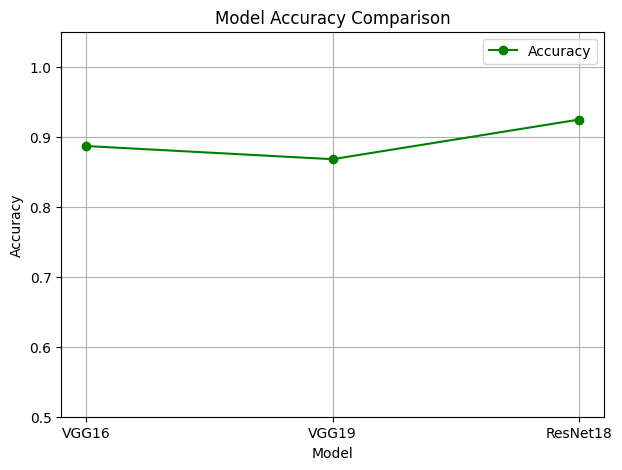

In [42]:
plt.figure(figsize=(7,5))
plt.plot(models, accuracy, marker='o', color='green', label='Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0.5, 1.05)
plt.grid(True)
plt.legend()
plt.show()

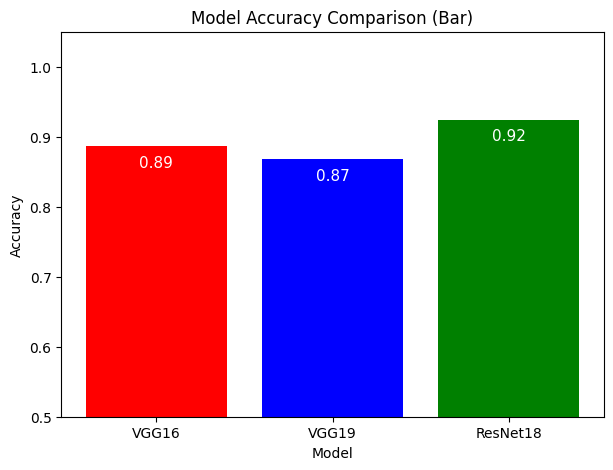

In [43]:
plt.figure(figsize=(7,5))
bars = plt.bar(models, accuracy, color=['red', 'blue', 'green'])
plt.title('Model Accuracy Comparison (Bar)')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0.5, 1.05)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.03, f'{bar.get_height():.2f}', ha='center', color='white', fontsize=11)
plt.show()

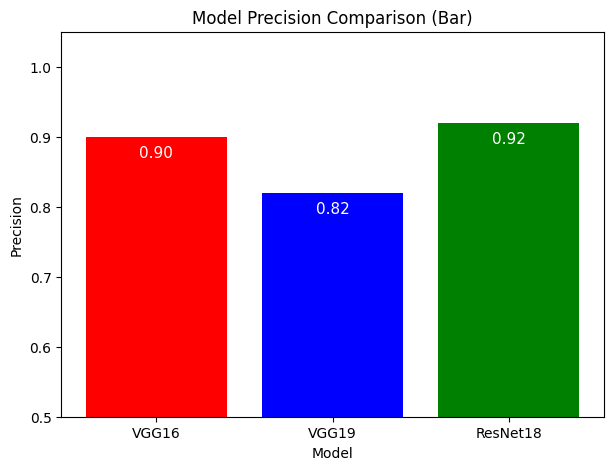

In [44]:
plt.figure(figsize=(7,5))
bars = plt.bar(models, precision, color=['red', 'blue', 'green'])
plt.title('Model Precision Comparison (Bar)')
plt.ylabel('Precision')
plt.xlabel('Model')
plt.ylim(0.5, 1.05)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.03, f'{bar.get_height():.2f}', ha='center', color='white', fontsize=11)
plt.show()

In [45]:
labels = ['Malnourished', 'Healthy']
x = np.arange(len(models))
width = 0.25

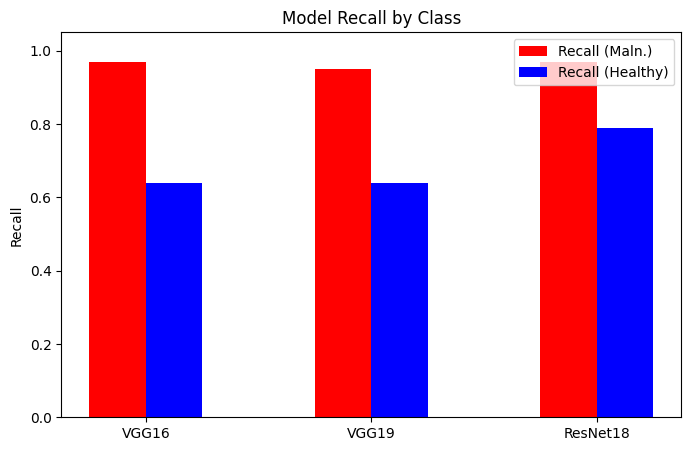

In [46]:
plt.figure(figsize=(8,5))
plt.bar(x - width/2, recall_malnourished, width, label='Recall (Maln.)', color='red')
plt.bar(x + width/2, recall_healthy, width, label='Recall (Healthy)', color='blue')
plt.xticks(x, models)
plt.ylabel('Recall')
plt.title('Model Recall by Class')
plt.ylim(0, 1.05)
plt.legend()
plt.show()

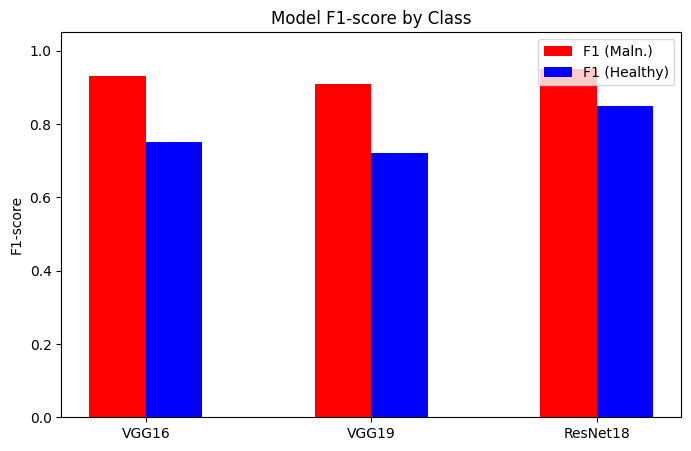

In [47]:
plt.figure(figsize=(8,5))
plt.bar(x - width/2, f1_malnourished, width, label='F1 (Maln.)', color='red')
plt.bar(x + width/2, f1_healthy, width, label='F1 (Healthy)', color='blue')
plt.xticks(x, models)
plt.ylabel('F1-score')
plt.title('Model F1-score by Class')
plt.ylim(0, 1.05)
plt.legend()
plt.show()